## Problema 5 

### Conjuntos 
$N$ : es el conjunto de Localidades $N =  \{0, 1, 2, 3, ..., n\}$

$K$ : es el conjunto de Equipos de inspeccion  $K =  \{1, 2, 3\}$
### Parametros 

- $C_{ij}$ --> Costo de viajar de la localidad $i$ a la localidad $j$ 

### Indices 
- $i ∈ N$ Recorre localidades
- $i ∈ N$ Recorre localidades
- $k ∈ K$ Representa equipos 

### Variable de decision 
$X_{ijk}$ : Variable binaria que indica si el equipo $k$ va de la localidad $i$ a la localidad $j$ 
$$ 
  X_{ijk} =
  \begin{cases} 
  1 & \text{si el equipo } k \text{ si va de la localidad } i \text{ a la localidad } j \text{} \\ 
  0 & \text{si el equipo } k \text{ si va de la localidad } i \text{ a la localidad } j \text{} \\ 
  \end{cases} 
  $$

### Funcion Objetivo 

Minimizar el costo total del recorrido de todos los equipos:

$$
\min \sum_{k \in K} \sum_{i \in N} \sum_{j \in N, i \neq j} c_{ij} \cdot x_{ijk}
$$

Esta función busca minimizar la distancia o el costo de viaje total recorrido por todos los equipos de inspección.


Camión 1: Nodo 0 → Nodo 8 → Nodo 0 → Nodo 0
Camión 2: Nodo 0 → Nodo 2 → Nodo 13 → Nodo 14 → Nodo 3 → Nodo 12 → Nodo 7 → Nodo 9 → Nodo 10 → Nodo 1 → Nodo 11 → Nodo 0 → Nodo 0
Camión 3: Nodo 0 → Nodo 4 → Nodo 0 → Nodo 0
Camión 4: Nodo 0 → Nodo 5 → Nodo 0 → Nodo 0
Camión 5: Nodo 0 → Nodo 6 → Nodo 0 → Nodo 0


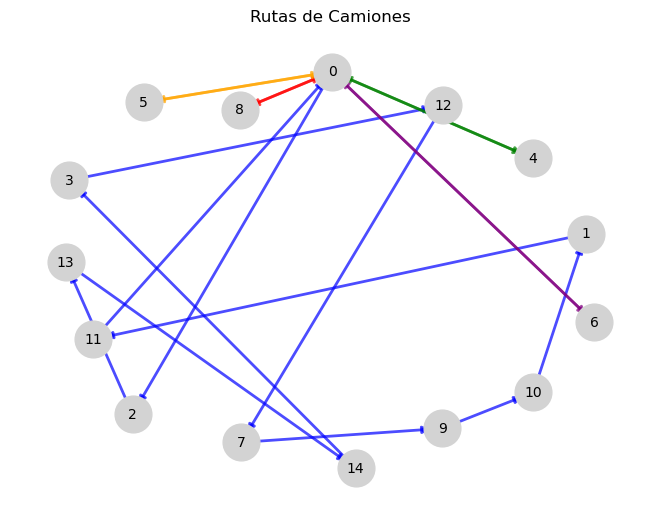

In [12]:
from pyomo.environ import *
import pandas as pd
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt

# Cargar la matriz de costos
#cost_matrix = pd.read_csv("/Users/amaliacarbonell/Documents/Septimo_Semestre/MOS/MOS-Laboratorios/Laboratorio 2/Problema 5/matrix_cost/cost_matrix_10_nodes_1.5_spread.csv").values
cost_matrix = pd.read_csv("./matrix_cost/cost_matrix_15_nodes_2.5_spread.csv").values

n = cost_matrix.shape[0]  # Número total de localidades

num_cities = n - 1  # Excluyendo el depósito si aplica
camiones = 5  # Número de camiones

# Crear modelo
model = ConcreteModel()

# Conjuntos
model.N = RangeSet(0, num_cities)  
model.K = RangeSet(1, camiones)  

# Variables de decisión
model.x = Var(model.N, model.N, model.K, within=Binary)  # 1 si si viaje de i a j, 0 si no viaja se i a j 
model.u = Var(model.N, model.K, within=NonNegativeReals)  # Variable  subtours

# Función objetivo 
def objetivo_rule(model):
    return sum(
        cost_matrix[i][j] * model.x[i, j, k]
        for k in model.K
        for i in model.N
        for j in model.N
        if i != j
    )

model.obj = Objective(rule=objetivo_rule, sense=minimize)


      
# Restriccion de entrada y salida a la localidad 0 
model.nodo_inicio = ConstraintList()
for k in model.K:
    model.nodo_inicio.add(sum(model.x[0, j, k] for j in model.N if j != 0) == 1)  # Salida 
    model.nodo_inicio.add(sum(model.x[j, 0, k] for j in model.N if j != 0) == 1)  # Entrada

# LO que entra al nodo medio sale del nodo medio 
model.nodos_intermedios = ConstraintList()
for k in model.K:
    for i in model.N:
        if i != 0:
            model.nodos_intermedios.add(
                sum(model.x[i, j, k] for j in model.N if i != j) ==
                sum(model.x[j, i, k] for j in model.N if i != j)
            )


# Restricción subtours
model.subtour = ConstraintList()
for k in model.K:
    for i in model.N:
        for j in model.N:
            if i != j and i != 0 and j != 0:
                model.subtour.add(model.u[i, k] - model.u[j, k] + num_cities * model.x[i, j, k] <= num_cities - 1)

# Restricción: cada nodo debe ser visitado una vez 
model.solounavez = ConstraintList()
for i in model.N:
    if i != 0:
        model.solounavez.add(sum(model.x[i, j, k] for j in model.N for k in model.K if i != j) == 1)

# Resolver el modelo
solver = SolverFactory('glpk')
solver.solve(model)


# Mostrar resultados
#model.display()

# Mostrar resultados por camion para entender y en grafica 
routes = {k: [] for k in model.K}

for k in model.K:
    current_node = 0  # Cada camión empieza en el nodo 0
    while True:
        for j in model.N:
            if j != current_node and model.x[current_node, j, k].value > 0.5:  
                routes[k].append(j)
                current_node = j
                break
        if current_node == 0:  
            break  

# Imprimir rutas de manera clara
for k, route in routes.items():
    route_str = " → ".join([f"Nodo {i}" for i in [0] + route + [0]])
    print(f"Camión {k}: {route_str}")


# Crear el grafo dirigido
G = nx.DiGraph()

# Agregar nodos
for i in model.N:
    G.add_node(i, pos=(np.random.rand(), np.random.rand()))  # Las localidades se ponen en forma aleatoria para visualizar
pos = nx.spring_layout(G, seed=42)  
nx.draw(G, pos, with_labels=True, node_color='lightgray', node_size=700, font_size=10)

# color por camión, se agregan muhcos colores para que no falle si no hay mas camiones 
colores = ['red', 'blue', 'green', 'orange', 'purple','yellow','cyan','pink', 'black','red', 'blue', 'green', 'orange', 'purple','yellow','cyan','pink', 'black','red', 'blue', 'green', 'orange', 'purple','yellow','cyan','pink', 'black']  # Asegúrate de tener suficientes colores
aristas = []
aristas_color = []

for k in model.K:
    for i in model.N:
        for j in model.N:
            if i != j and model.x[i, j, k].value > 0.5:
                G.add_edge(i, j)
                aristas.append((i, j))
                aristas_color.append(colores[k-1])  # Asignar color según camión




# Dibujar camino por camión
nx.draw_networkx_edges(G, pos, edgelist=aristas, edge_color=aristas_color, width=2, alpha=0.7)

# Mostrar la gráfica
plt.title("Rutas de Camiones")
plt.show()